## Starting a 7-day data challenge to answer one critical business question: Where should the company focus its marketing budget to maximize profit over the next quarter?


# Importing Libraries

In [4]:
import pandas as pd
import numpy as np


Loading data

In [6]:
# 1. Data Loading
try:

  df_orders = pd.read_csv('olist_orders_dataset.csv')
  df_items = pd.read_csv('olist_order_items_dataset.csv')
  df_products = pd.read_csv('olist_products_dataset.csv')
  df_customers = pd.read_csv('olist_customers_dataset.csv')
  print("All core datasets are loaded successfull.")
except FileNotFoundError as e:
  print(f"Error: File Not Found. Check File Name and Path: {e}")

All core datasets are loaded successfull.


## Data Wrangling

In [8]:
# Here we are going to join the tables and creating a master table
# join 1 Orders to Order item using Order_ID
# It is an On to many join since one order can have morethan one item

df_master = pd.merge(df_orders, df_items, on='order_id', how='inner')
print(f"Merge 1 Complet. Current size: {df_master.shape[0]} rows.")

# Join 2 Adding product details using product_id

df_master = pd.merge(df_master, df_products[['product_id', 'product_category_name']],
                     on='product_id', how= 'left')
print(f"Merge 2 Complete. Current size: {df_master.shape[0]} rows.")

# Join 3 Adding customer Location. using customer_id
# Taking customers' states as geography
df_master = pd.merge(df_master, df_customers[['customer_id', 'customer_state']],
                    on='customer_id', how='left')
print(f"Merge 3 Complete. Final size: {df_master.shape[0]} rows.")


Merge 1 Complet. Current size: 112650 rows.
Merge 2 Complete. Current size: 112650 rows.
Merge 3 Complete. Final size: 112650 rows.


In [9]:
# Read the saved CSV back
df_preview = pd.read_csv('olist_master_analytical_table.csv')

print("\n--- Verification: Preview of the Final Analytical Table ---")
# Display the shape (rows, columns) to confirm the size
print(f"Shape of the saved table: {df_preview.shape}")

# Display the first 10 rows and all columns
with pd.option_context('display.max_columns', None):
    print(df_preview.head(10))

print("\n--- Data Types Check ---")
print(df_preview.info())


--- Verification: Preview of the Final Analytical Table ---
Shape of the saved table: (108659, 7)
                           order_id order_purchase_timestamp  \
0  e481f51cbdc54678b7cc49136f2d6af7         02-10-2017 10:56   
1  53cdb2fc8bc7dce0b6741e2150273451         24-07-2018 20:41   
2  47770eb9100c2d0c44946d9cf07ec65d         08-08-2018 08:38   
3  949d5b44dbf5de918fe9c16f97b45f8a         18-11-2017 19:28   
4  ad21c59c0840e6cb83a9ceb5573f8159         13-02-2018 21:18   
5  a4591c265e18cb1dcee52889e2d8acc3         09-07-2017 21:57   
6  6514b8ad8028c9f2cc2374ded245783f         16-05-2017 13:10   
7  76c6e866289321a7c93b82b54852dc33         23-01-2017 18:29   
8  e69bfb5eb88e0ed6a785585b27e16dbf         29-07-2017 11:55   
9  e6ce16cb79ec1d90b1da9085a6118aeb         16-05-2017 19:41   

  order_delivered_customer_date   price  freight_value  product_category_name  \
0              10-10-2017 21:25   29.99           8.72  utilidades_domesticas   
1              07-08-2018 15:27  1

# Data Cleanning

In [11]:
# droping rowas where KPI or Critical segmentation is not avilable.
# Should have a category name to segment and a delivery date for the efficiency KPI

df_master.dropna(subset=['product_category_name', 'order_delivered_customer_date'], inplace= True)
print(f"\nCleanning Complete, Final Size: {df_master.shape[0]} rows.")

# Selecting the final columns for analysis
final_columns = ['order_id', 'order_purchase_timestamp', 'order_delivered_customer_date',
    'price', 'freight_value', 'product_category_name', 'customer_state'
    ]
df_master_clean = df_master[final_columns].copy()

# Printing the final view
print("Master Analystical Columns- First 5 Rows")
print(df_master_clean.head)
print("\nDescriptive Stats Check:")
print(df_master_clean.describe())




Cleanning Complete, Final Size: 108659 rows.
Master Analystical Columns- First 5 Rows
<bound method NDFrame.head of                                 order_id order_purchase_timestamp  \
0       e481f51cbdc54678b7cc49136f2d6af7         02-10-2017 10:56   
1       53cdb2fc8bc7dce0b6741e2150273451         24-07-2018 20:41   
2       47770eb9100c2d0c44946d9cf07ec65d         08-08-2018 08:38   
3       949d5b44dbf5de918fe9c16f97b45f8a         18-11-2017 19:28   
4       ad21c59c0840e6cb83a9ceb5573f8159         13-02-2018 21:18   
...                                  ...                      ...   
112645  63943bddc261676b46f01ca7ac2f7bd8         06-02-2018 12:58   
112646  83c1379a015df1e13d02aae0204711ab         27-08-2017 14:46   
112647  11c177c8e97725db2631073c19f07b62         08-01-2018 21:28   
112648  11c177c8e97725db2631073c19f07b62         08-01-2018 21:28   
112649  66dea50a8b16d9b4dee7af250b4be1a5         08-03-2018 20:57   

       order_delivered_customer_date   price  freight_

In [12]:
df_master_clean.to_csv('olist_master_analytical_table.csv', index=False)
print("\n Clean table saved as 'olist_master_analytical_table.csv' for Day 3.")


 Clean table saved as 'olist_master_analytical_table.csv' for Day 3.


## Efficiency KPI (Delivery Time)

In [14]:
df_master_clean['order_purchase_timestamp'] = pd.to_datetime(df_master_clean['order_purchase_timestamp'], format='%d-%m-%Y %H:%M'
                                                            )
df_master_clean['order_delivered_customer_date'] = pd.to_datetime(df_master_clean['order_delivered_customer_date'],format='%d-%m-%Y %H:%M'
                                                                 )

# Calculating Delivery time in days for finding efficiency KPI
df_master_clean['delivery_time_days'] = (df_master_clean['order_delivered_customer_date'] - df_master_clean['order_purchase_timestamp']).dt.total_seconds()/(60*60*24)

# To handle negative/zero delivery times for data integrity
df_master_clean.loc[df_master_clean['delivery_time_days']<= 0, 'delivery_time_days'] = np.nan

print("Delivery Time feature created.")


Delivery Time feature created.


## Calculating Revenue and Efficiancy KPIs 

In [16]:
# Revenue and Odrers by Category
df_revenue_kpi = df_master_clean.groupby('product_category_name').agg(
    Total_Revenue_Dollars=('price', 'sum'),
    Total_Orders=('order_id', 'nunique'),
    Order_Shipped=('order_id', 'nunique')
).reset_index()

# Efficiancy By State
df_efficiency_kpi = df_master_clean.groupby('customer_state').agg(
    Avg_Delivery_Time_Days=('delivery_time_days', 'mean'),
    Orders_Shipped=('order_id', 'nunique')
).reset_index()

print("\n KPIs Calculated!!!")
print("------------------------")
print("\nTop 5 Revenue Categories:\n", df_revenue_kpi.sort_values(by='Total_Revenue_Dollars', ascending=False).head())


 KPIs Calculated!!!
------------------------

Top 5 Revenue Categories:
      product_category_name  Total_Revenue_Dollars  Total_Orders  Order_Shipped
11            beleza_saude             1233211.61          8649           8649
66      relogios_presentes             1165898.98          5493           5493
13         cama_mesa_banho             1023434.76          9272           9272
32           esporte_lazer              954695.05          7530           7530
44  informatica_acessorios              888613.62          6529           6529


In [54]:
# Saving these data for Visualisation
df_revenue_kpi.to_csv('kpi_revenue_by_category.csv', index=False)
df_efficiency_kpi.to_csv('kpi_efficiency_by_state.csv', index=False)

print("\nFiles saved for Day 4 EDA and Day 5 Visualization.")


Files saved for Day 4 EDA and Day 5 Visualization.


## Exploratory Analysis (EDA)

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns


#Loading the aggregated KPIs
df_revenue = pd.read_csv('kpi_revenue_by_category.csv')
df_efficiency_state = pd.read_csv('kpi_efficiency_by_state.csv')

# Step 1. Combine Revenue and Efficiency
# NOTE: Since Efficiency is by STATE and Revenue is by CATEGORY, we need to pick a proxy, like the average efficiency across the whole dataset OR -
# focus the EDA on the TOP 10 REVENUE categories.

df_eda = df_revenue.sort_values(by='Total_Revenue_Dollars', ascending=False).head(10).copy()

# New Insight Metric: Revenue per Order (AOV)- our proxy for the "surprising trend" in the visual
df_eda['AOV_Category'] = df_eda['Total_Revenue_Dollars'] / df_eda['Total_Orders']




Day 4 Visualization generated and saved!


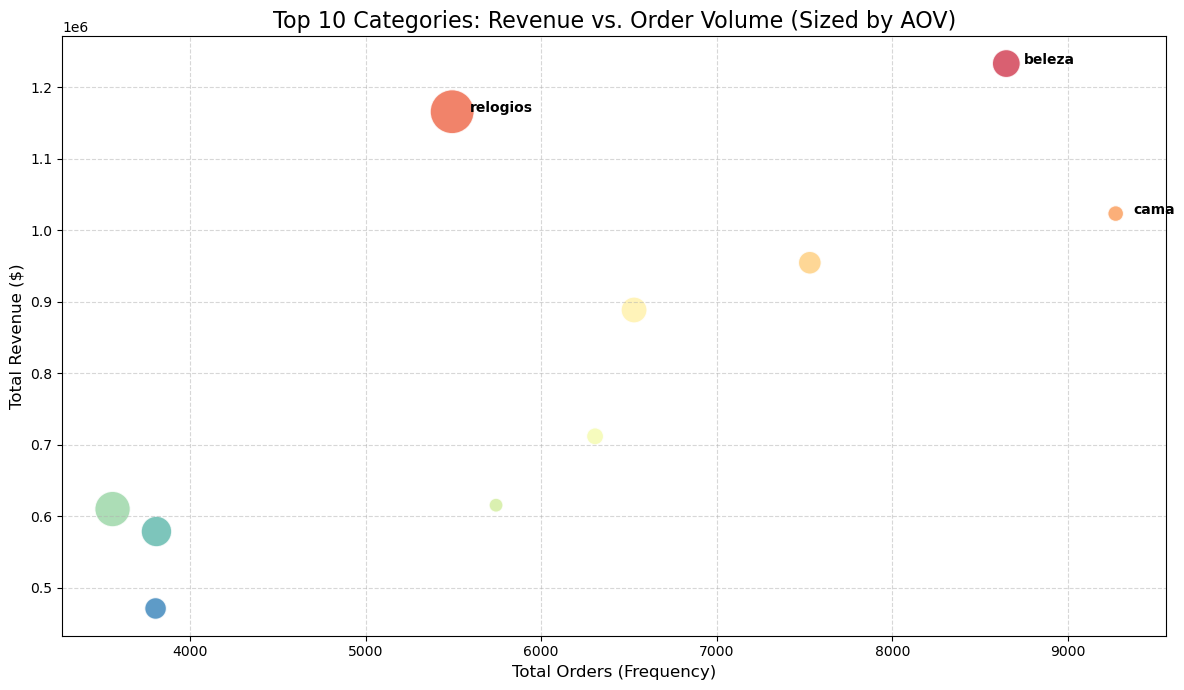

In [42]:
# Step 2. Creating Visualization

plt.figure(figsize=(12, 7))

# Create a scatter plot to analyze Revenue vs. Order Volume, sized by AOV
scatter = sns.scatterplot(
    data=df_eda,
    x='Total_Orders',
    y='Total_Revenue_Dollars',
    size='AOV_Category',  # Use Average Order Value (AOV) to size the bubbles
    sizes=(100, 1000),
    hue='product_category_name',
    legend=False,
    palette='Spectral',
    alpha= 0.8
)

plt.title('Top 10 Categories: Revenue vs. Order Volume (Sized by AOV)', fontsize=16)
plt.xlabel('Total Orders (Frequency)', fontsize=12)
plt.ylabel('Total Revenue ($)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Annotate the top 3 highest revenue categories (The "Surprising Trends")
for i, row in df_eda.head(3).iterrows():
    plt.text(row['Total_Orders'] + 100, row['Total_Revenue_Dollars'],
             row['product_category_name'].split('_')[0], 
             fontsize=10, weight='bold')

plt.tight_layout()
# Save the plot
plt.savefig('day4_eda_scatter_plot.png')
print("\nDay 4 Visualization generated and saved!")
